# COVID-19: How long until herd immunity?
> Tracking the number of infected cases per country

- comments: true
- author: Caglar Cakan
- categories: [covid19]
- permalink: /covid-herd-immunity/
- image: images/icon_herd_immunity.png
- license: Creative Commons

In [1]:
#hide_input
import datetime
print("Last build ", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

Last build  25.04.20 21:03:03


In [30]:
#hide

# altair code borrowed from Pratap Vardhan, https://github.com/machine-learning-apps/covid19-dashboard/blob/master/_notebooks/2020-03-17-covid19-compare-country-death-trajectories.ipynb
# load_timeseries code borrowed from Thomas Wiecki & Hamel Husain, https://github.com/machine-learning-apps/covid19-dashboard/blob/master/_notebooks/2020-03-16-covid19_growth_bayes.ipynb
# Thanks!

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

import requests
import io

sns.set_context('talk')
plt.style.use('ggplot')

In [3]:
#hide
def load_timeseries(name, 
                    base_url='https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series'):
    import requests
    # Thanks to kasparthommen for the suggestion to directly download
    url = f'{base_url}/time_series_covid19_{name}_global.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'

    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Fix South Korea
    df.loc[df.country =='Korea, South', 'country'] = 'South Korea'
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = (df.groupby(["date", "country", "type"])
          .sum()
          .reset_index()
          .sort_values(["country", "date"])
          .set_index("date"))
    return df

In [ ]:
#hide

def get_countries_with_min_cases_for_df(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)
           ].sort_values(by=by, ascending=False)
    countries = countries['country'].values
    return countries

def get_countries_with_min_cases(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)].sort_values(by=by, ascending=False)
    countries = countries['country'].unique()
    return countries

def filter_cases(df_cases, by='cases', min_cases = 10, since_cases=None):
    countries = get_countries_with_min_cases_for_df(df_cases, by, min_cases)
    if since_cases is None:
        SINCE_CASES_NUM = 100
    else:
        SINCE_CASES_NUM = since_cases
        
    COL_X = f'Days since case {SINCE_CASES_NUM}'
    dff2 = df_cases[df_cases['country'].isin(countries)].copy()
    dff2['date'] = dff2.index
    days_since = (dff2.assign(F=dff2[by].ge(SINCE_CASES_NUM))
                  .set_index('date')
                  .groupby('country')['F'].transform('idxmax'))
    dff2[COL_X] = (dff2['date'] - days_since.values).dt.days.values
    dff2 = dff2[dff2[COL_X].ge(0)]
    return dff2

In [ ]:
#hide
df_deaths = load_timeseries("deaths")
df_confirmed = load_timeseries("confirmed")

# concatenate both timeseries
df_cases = pd.concat((df_confirmed, df_deaths), axis=1)
df_cases.columns = ['country', 'type', 'confirmed', 'country', 'type', 'deaths']
df_cases = df_cases.loc[:,~df_cases.columns.duplicated()]

In [ ]:
# dirty ratio
df_cases['ratio'] = df_cases.confirmed / (df_cases.deaths + 1)

df_cases['fatality'] = (df_cases['deaths'] / df_cases['confirmed'].round(1))

In [ ]:
# create diffs
df_cases['new_deaths'] = df_cases.deaths.diff()
# flatten artifacts from one country to the next
df_cases.loc[df_cases['new_deaths']<0, 'new_deaths'] = 0
df_cases['new_confirmed'] = df_cases.confirmed.diff()
df_cases.loc[df_cases['new_confirmed']<0, 'new_confirmed'] = 0

In [8]:
#hide
MIN_CASES = 10000
SINCE_CASES = 50
dff2 = filter_cases(df_cases, 'confirmed', MIN_CASES, SINCE_CASES)

In [9]:
#hide
MIN_DEATHS = 100
get_countries_with_min_cases(df_cases, 'deaths', MIN_DEATHS)

array(['US', 'Italy', 'Spain', 'France', 'United Kingdom', 'Belgium',
       'Germany', 'Iran', 'China', 'Netherlands', 'Brazil', 'Turkey',
       'Canada', 'Sweden', 'Switzerland', 'Mexico', 'Ireland', 'Portugal',
       'India', 'Indonesia', 'Peru', 'Russia', 'Ecuador', 'Romania',
       'Austria', 'Poland', 'Philippines', 'Algeria', 'Denmark', 'Japan',
       'Egypt', 'Dominican Republic', 'Hungary', 'Pakistan',
       'South Korea', 'Colombia', 'Czechia', 'Ukraine', 'Norway',
       'Israel', 'Finland', 'Argentina', 'Chile', 'Morocco', 'Panama',
       'Bangladesh', 'Greece', 'Saudi Arabia', 'Serbia'], dtype=object)

US: 0.28% (6559 days necessary to infect 60% of the population of 319259000 at an infection rate of 29201 cases/day)
Italy: 0.32% (11239 days necessary to infect 60% of the population of 60769102 at an infection rate of 3244 cases/day)
Spain: 0.47% (6353 days necessary to infect 60% of the population of 46507760 at an infection rate of 4392 cases/day)
France: 0.24% (7884 days necessary to infect 60% of the population of 66078000 at an infection rate of 5028 cases/day)
United Kingdom: 0.23% (7688 days necessary to infect 60% of the population of 64105654 at an infection rate of 5002 cases/day)
Belgium: 0.39% (5349 days necessary to infect 60% of the population of 11225469 at an infection rate of 1259 cases/day)
Germany: 0.19% (20670 days necessary to infect 60% of the population of 80783000 at an infection rate of 2344 cases/day)
Iran: 0.11% (32742 days necessary to infect 60% of the population of 77966400 at an infection rate of 1428 cases/day)
Netherlands: 0.22% (10519 days necessary 

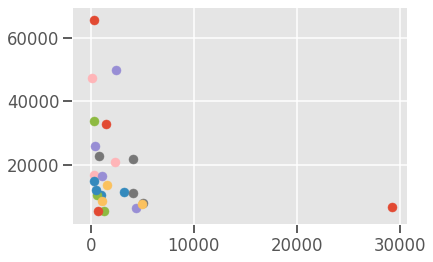

In [92]:

from countryinfo import CountryInfo
ignore = ["China"]

countries = get_countries_with_min_cases(dff2, 'deaths', MIN_DEATHS)[:]
countries = [c for c in countries if c not in ignore]

infected_population_list = []
days_until_full_infection_list = []
new_cases_mean_list = []

for str_country in countries:
    #print(f"{str_country}")
    df_cases_country = dff2[dff2['country']==str_country]
    country_info_str = str_country
    if str_country == "US":
        country_info_str = "United States"
        
    population = CountryInfo(country_info_str).population()

    last_new_cases = df_cases_country.new_confirmed[-1]
    
    MEAN_CASES_DAYS = 14
    new_cases_mean = np.mean(df_cases_country.new_confirmed[-MEAN_CASES_DAYS:])
    new_cases_mean_list.append(new_cases_mean)
    
    HERD_IMMUNITY_THRESHOLD = 0.6
    days_until_full_infection = int(population/new_cases_mean * HERD_IMMUNITY_THRESHOLD)
    days_until_full_infection_list.append(days_until_full_infection)
    
    infected_population = df_cases_country.confirmed[-1] / population * 100
    infected_population_list.append(infected_population)
    
    print(f"{str_country}: {infected_population:.2}% ({days_until_full_infection} days necessary to infect {int(HERD_IMMUNITY_THRESHOLD*100)}% of the population of {population} at an infection rate of {int(new_cases_mean)} cases/day)")
    
asymptomatic_population_list = np.multiply(infected_population_list, 3)

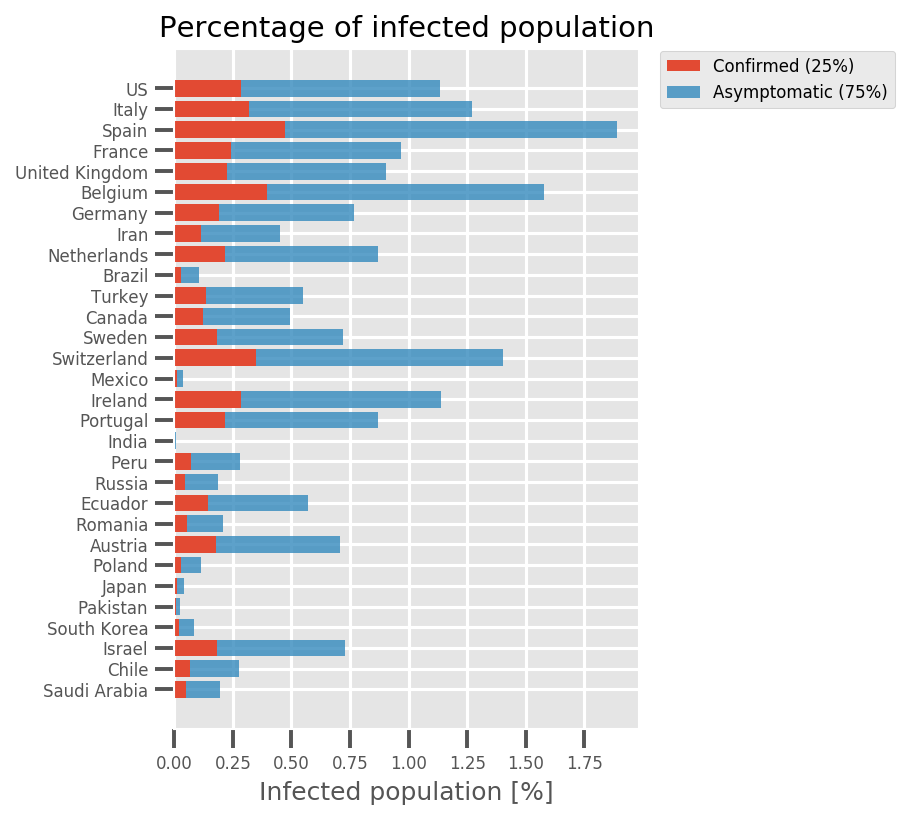

In [138]:
fig, axs = plt.subplots(1, 1, figsize=(4, len(countries)/5), dpi=150)
plt.barh(countries[::-1], infected_population_list[::-1], color='C0', label='Confirmed (25%)')
plt.barh(countries[::-1], asymptomatic_population_list[::-1], left=infected_population_list[::-1], color='C1', label='Asymptomatic (75%)', ls='--', alpha=0.8,lw=1)


# for i, c in enumerate(countries):
#     plt.text(infected_population_list[i] + 0.05, i-0.4, f"{days_until_full_infection_list[i]}", textsize=10, font='r')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.title("Percentage of infected population", fontsize=14)
plt.xlabel("Infected population [%]", fontsize=12)
plt.legend(bbox_to_anchor=(np.max(asymptomatic_population_list)+0.15, 1.01), fontsize=8)
plt.savefig("../images/icon_herd_immunity.png")

US


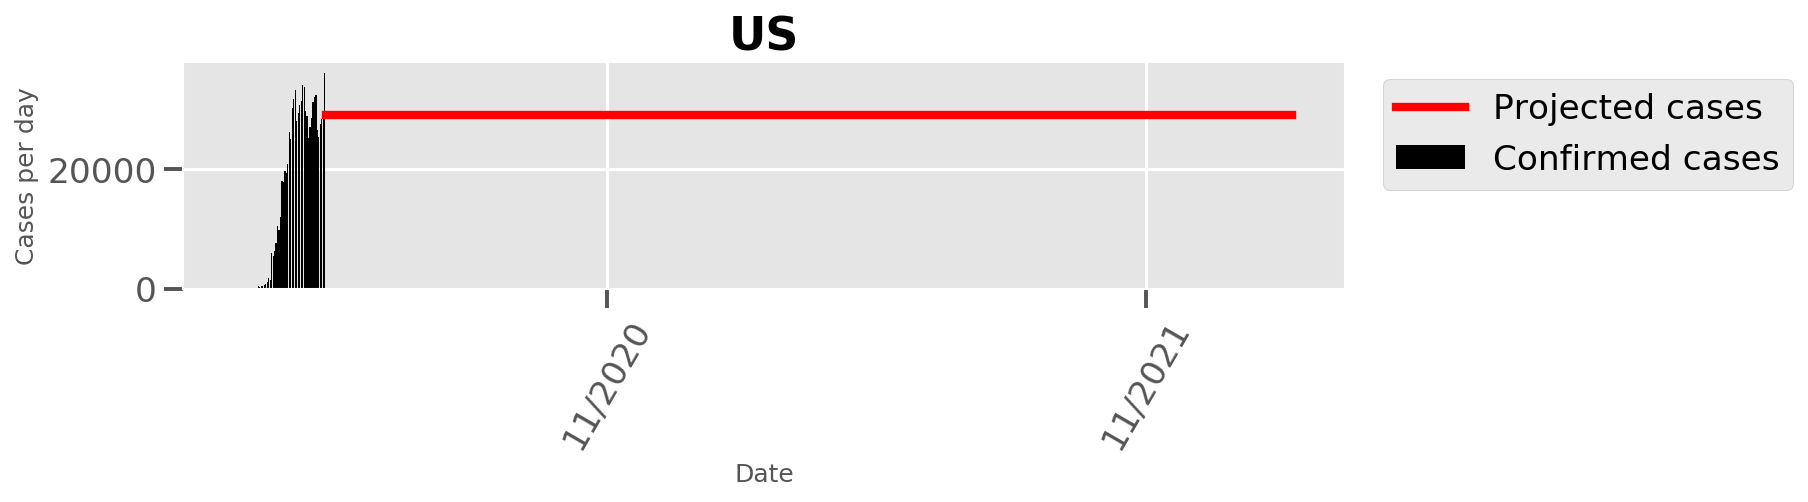

Italy


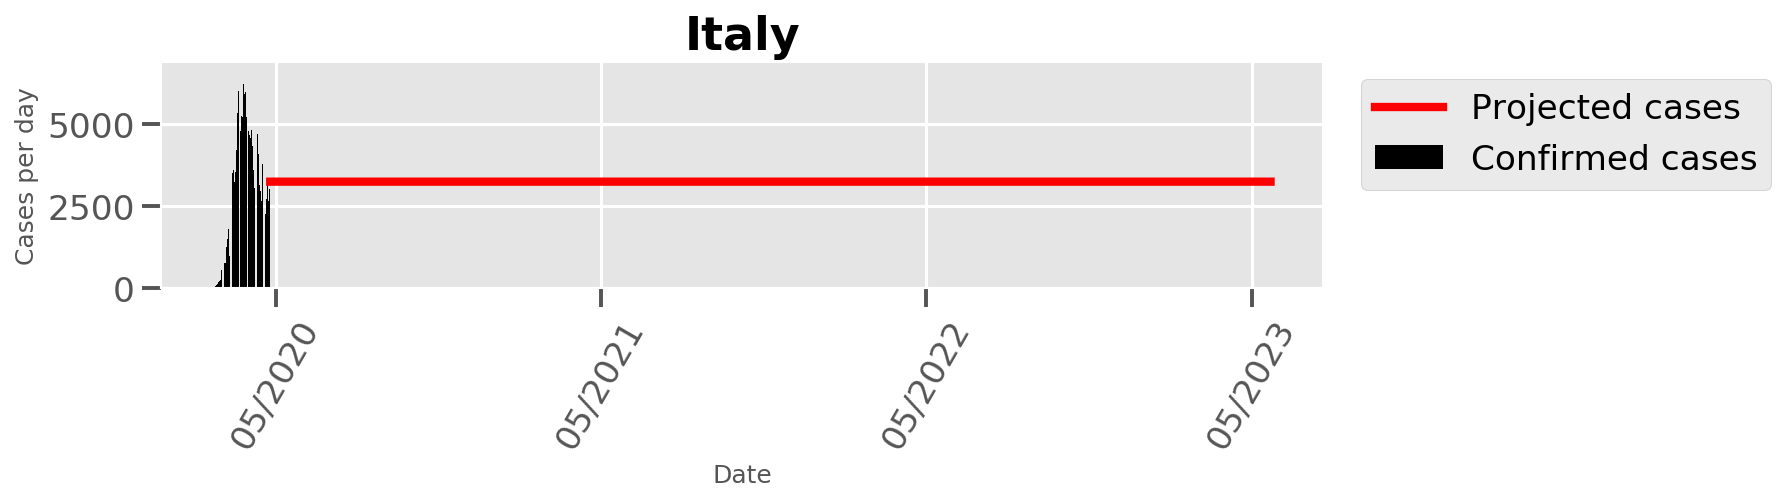

Spain


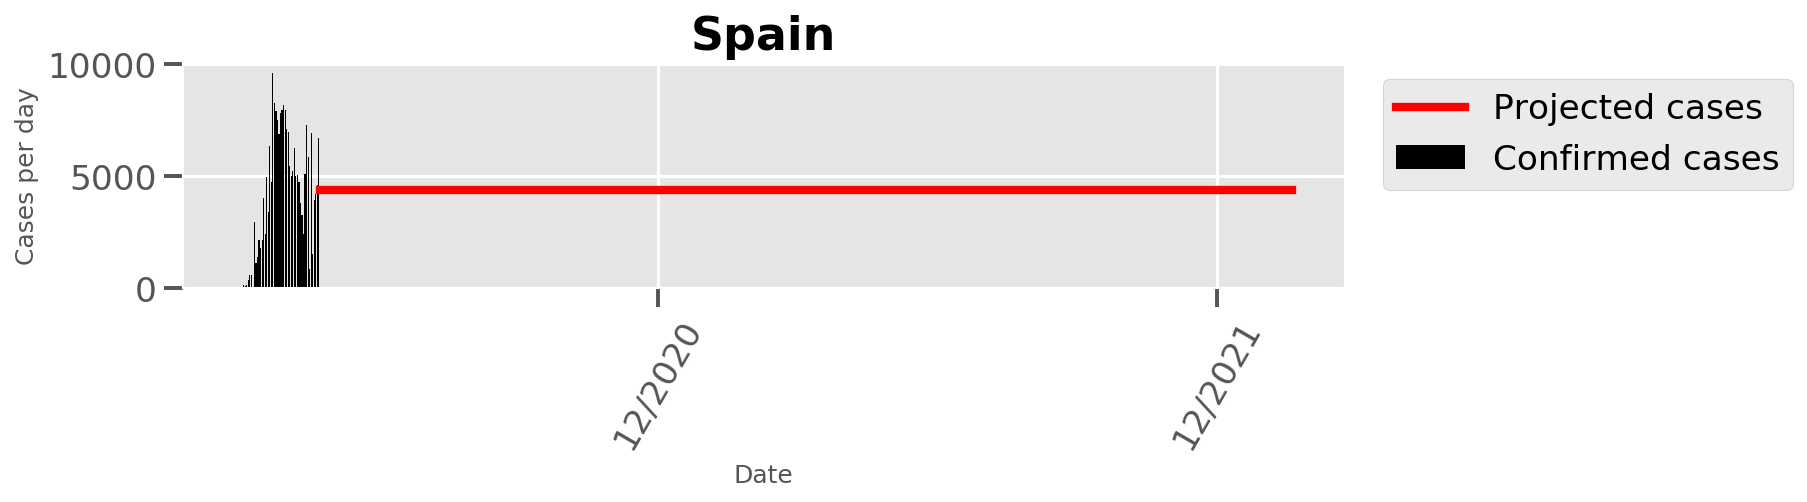

France


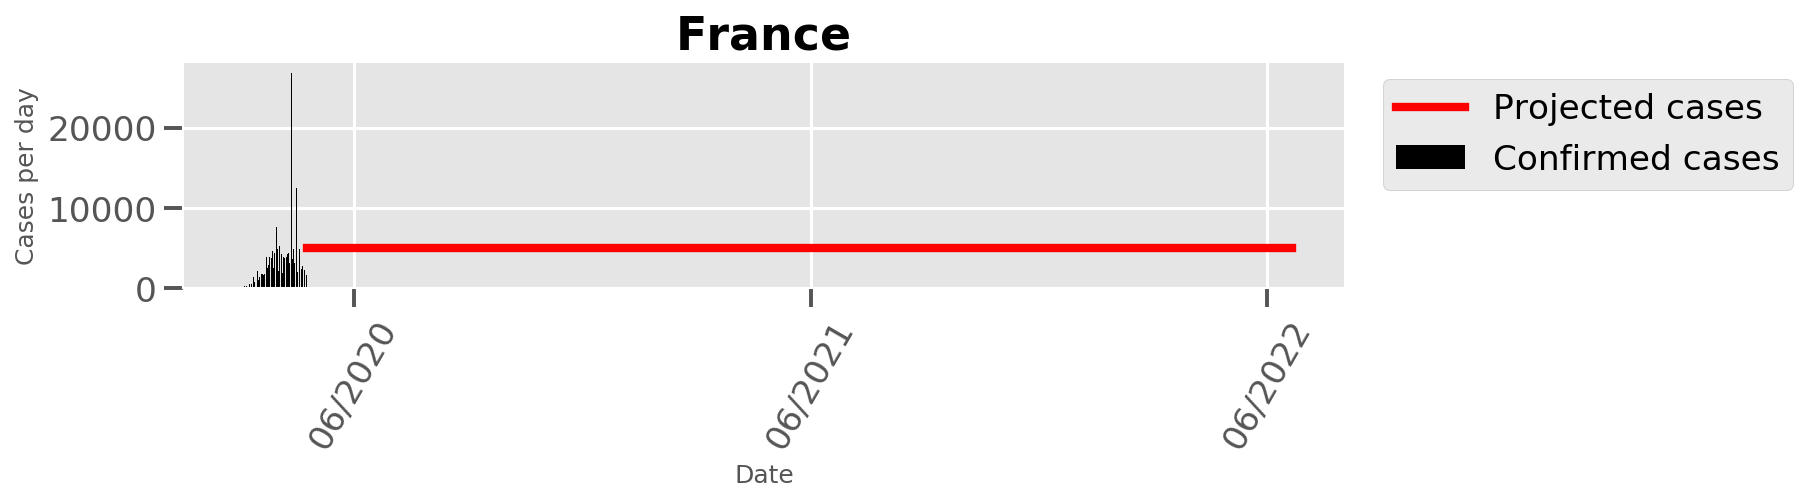

United Kingdom


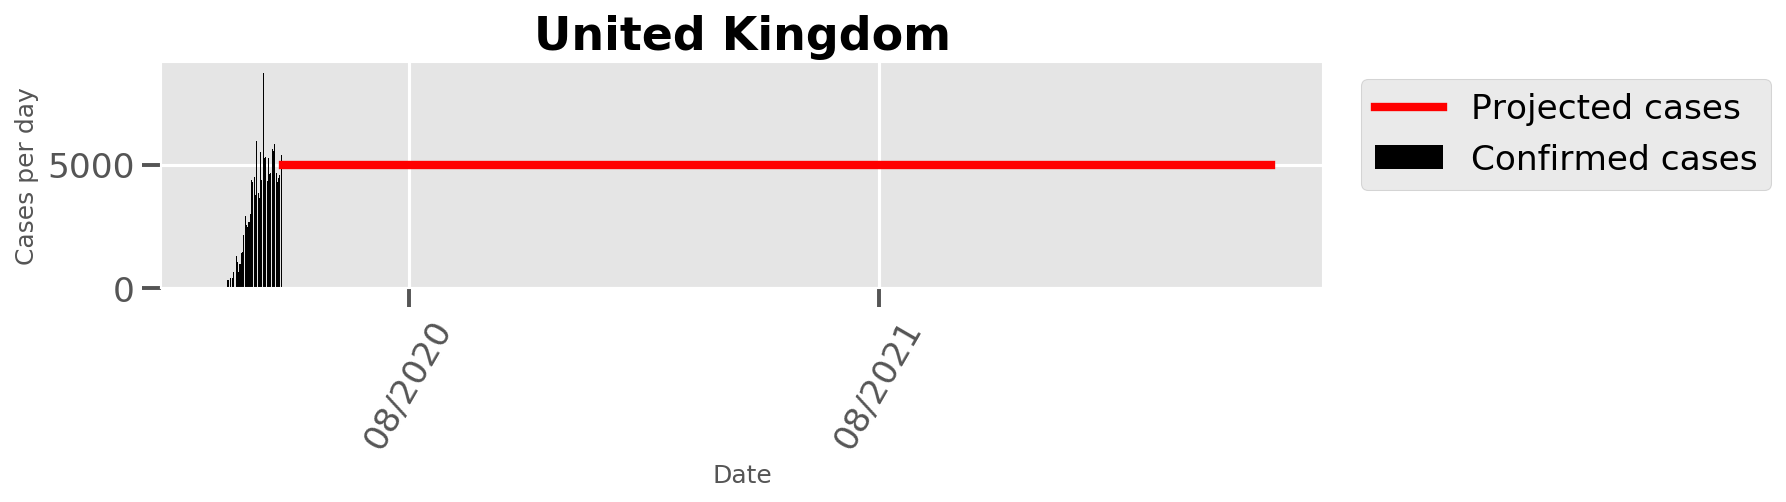

Belgium


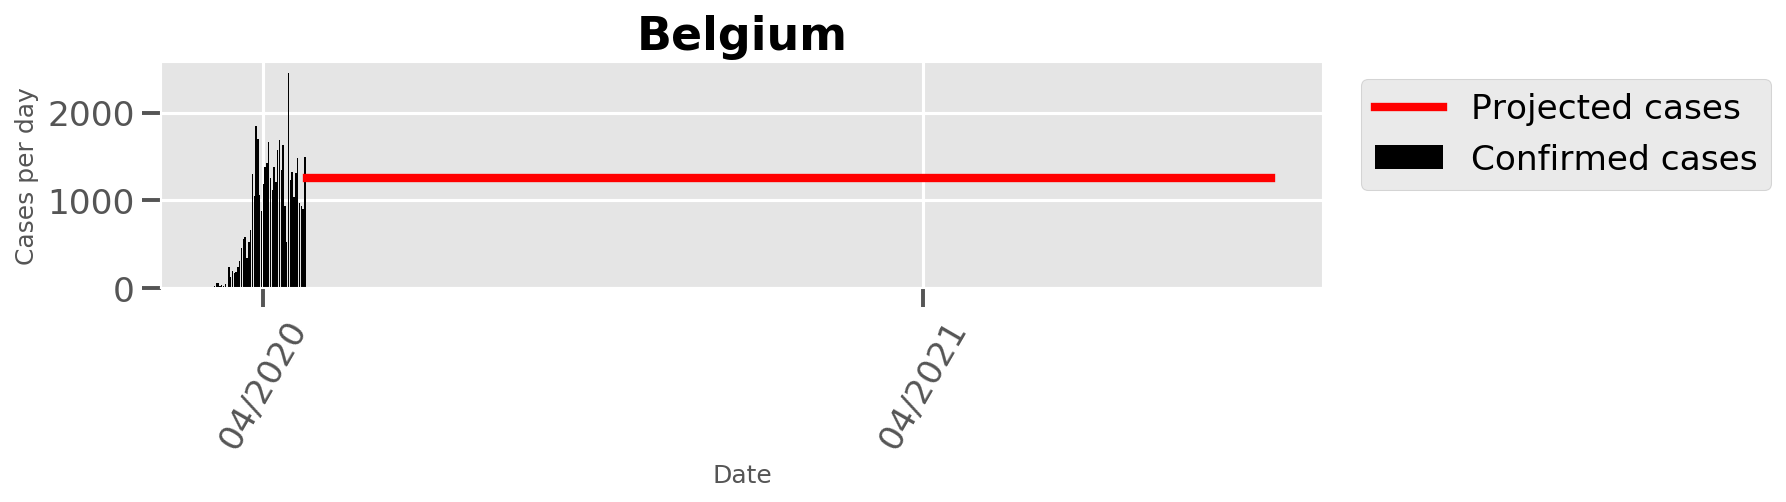

Germany


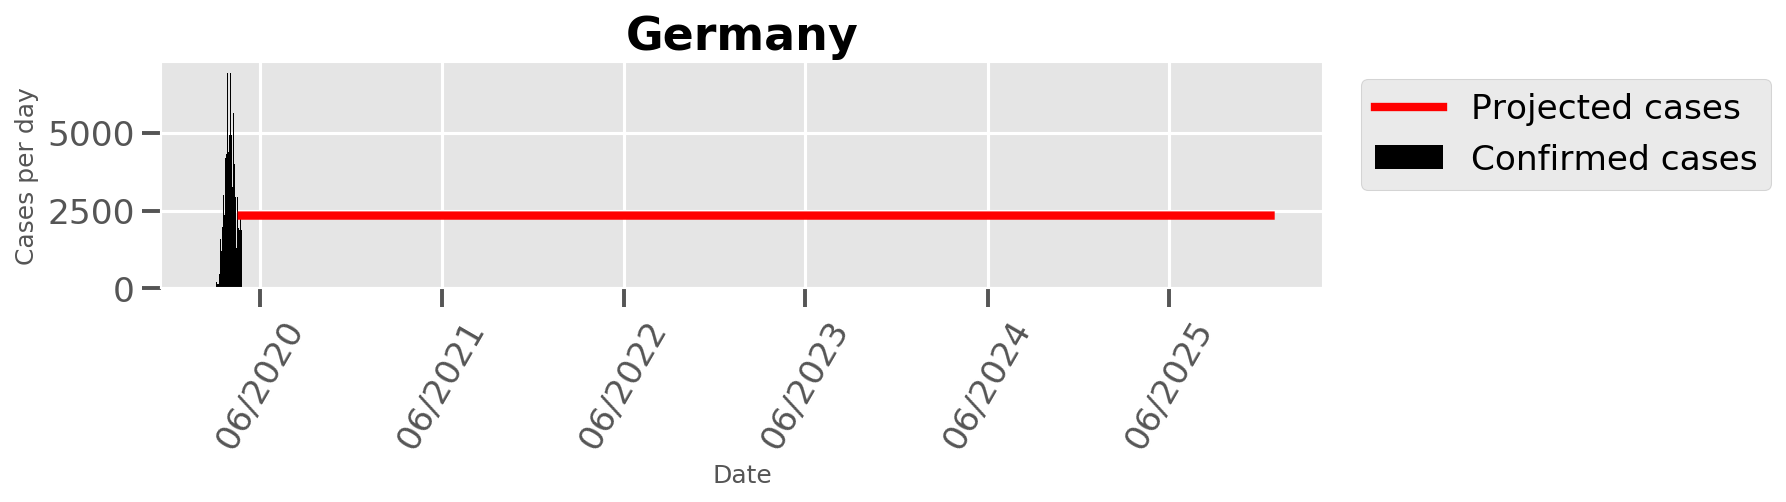

Iran


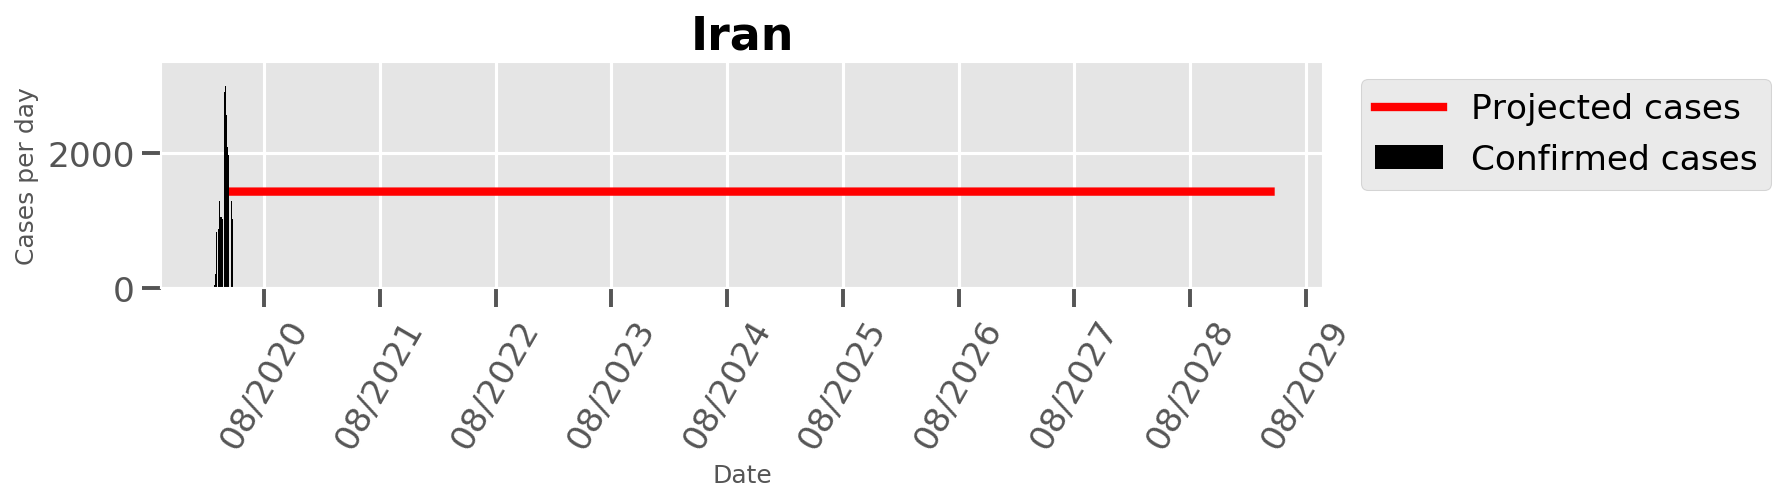

Netherlands


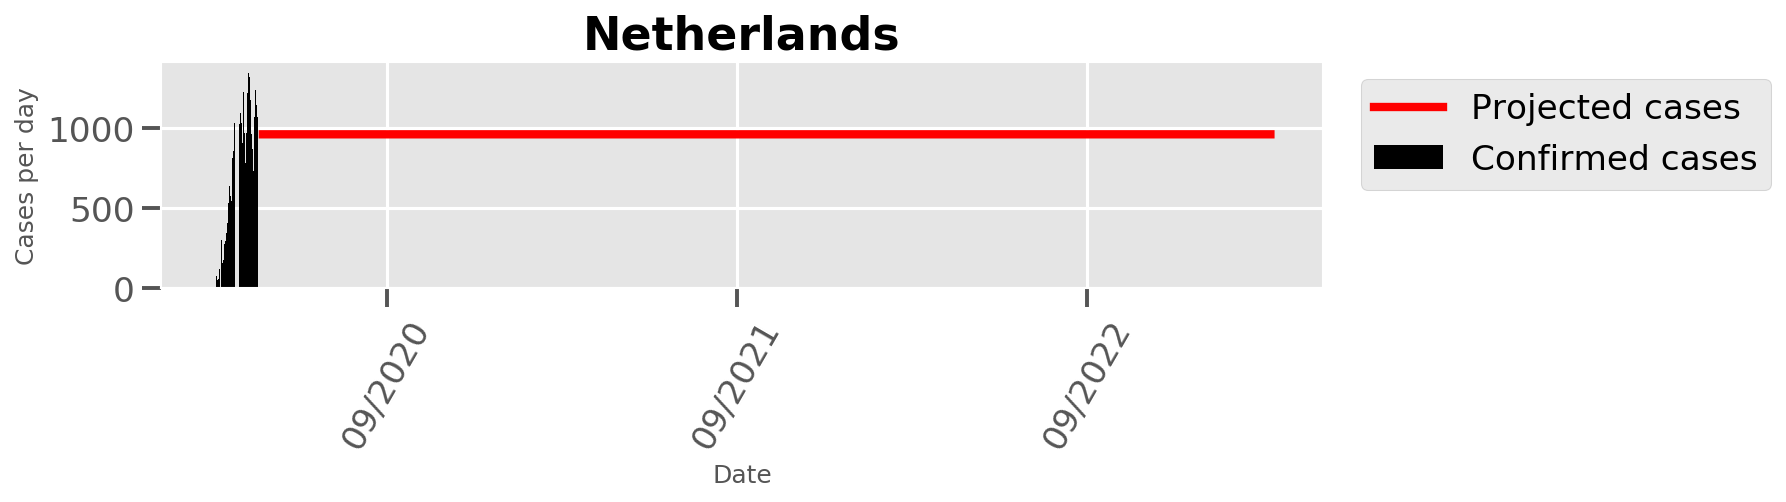

Brazil


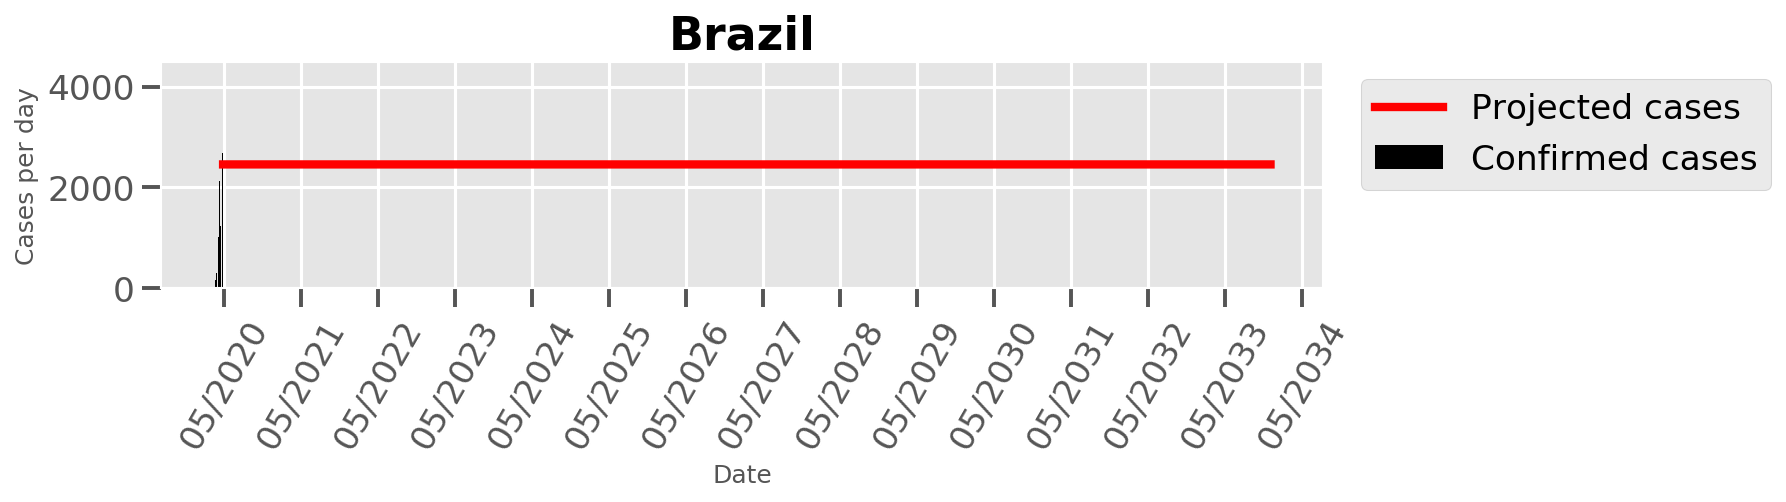

Turkey


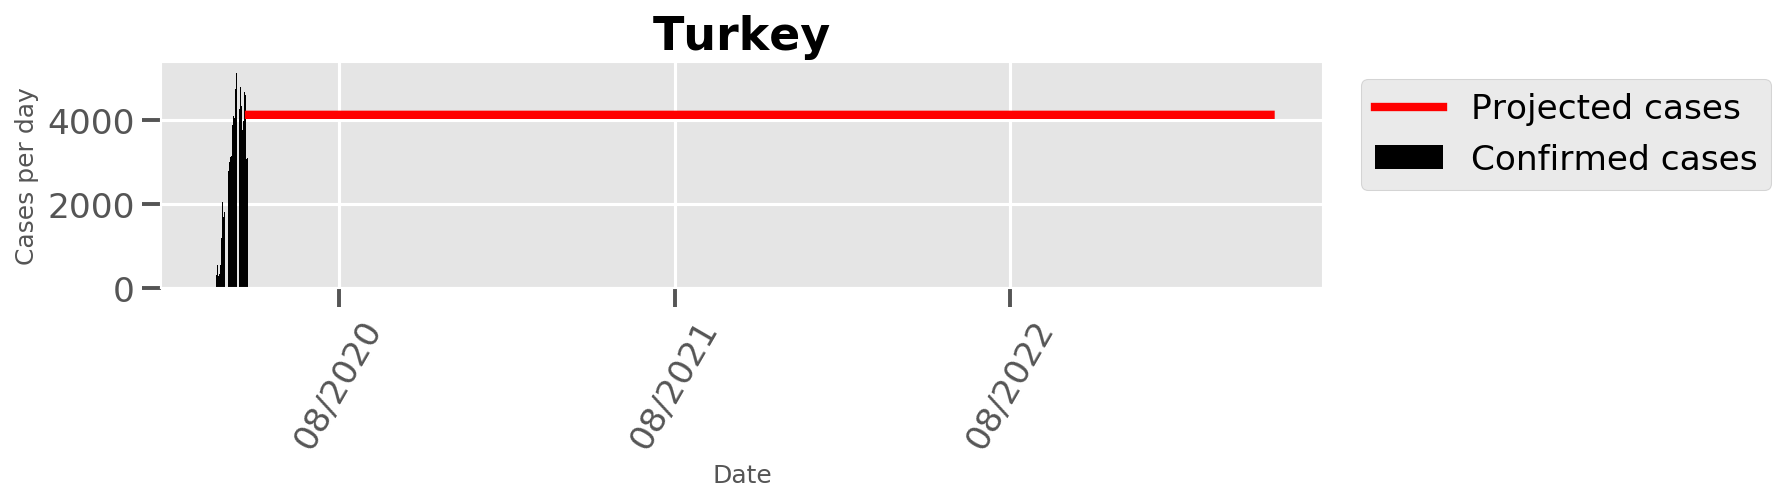

Canada


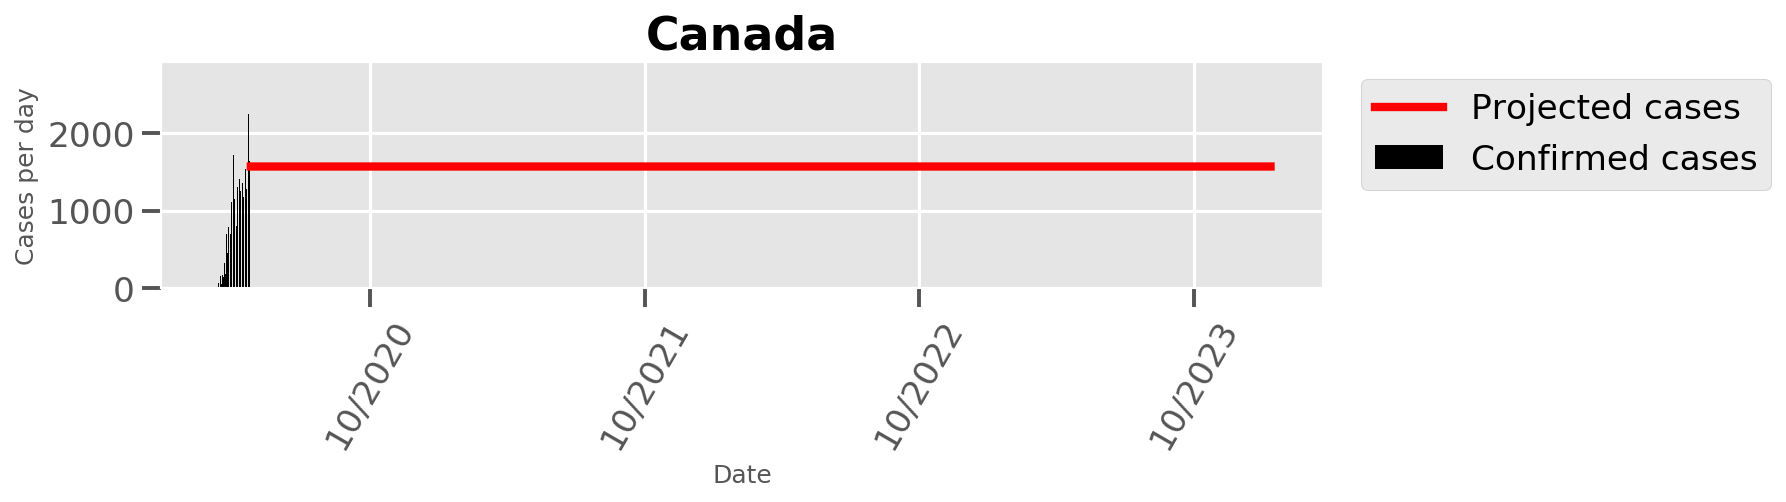

Sweden


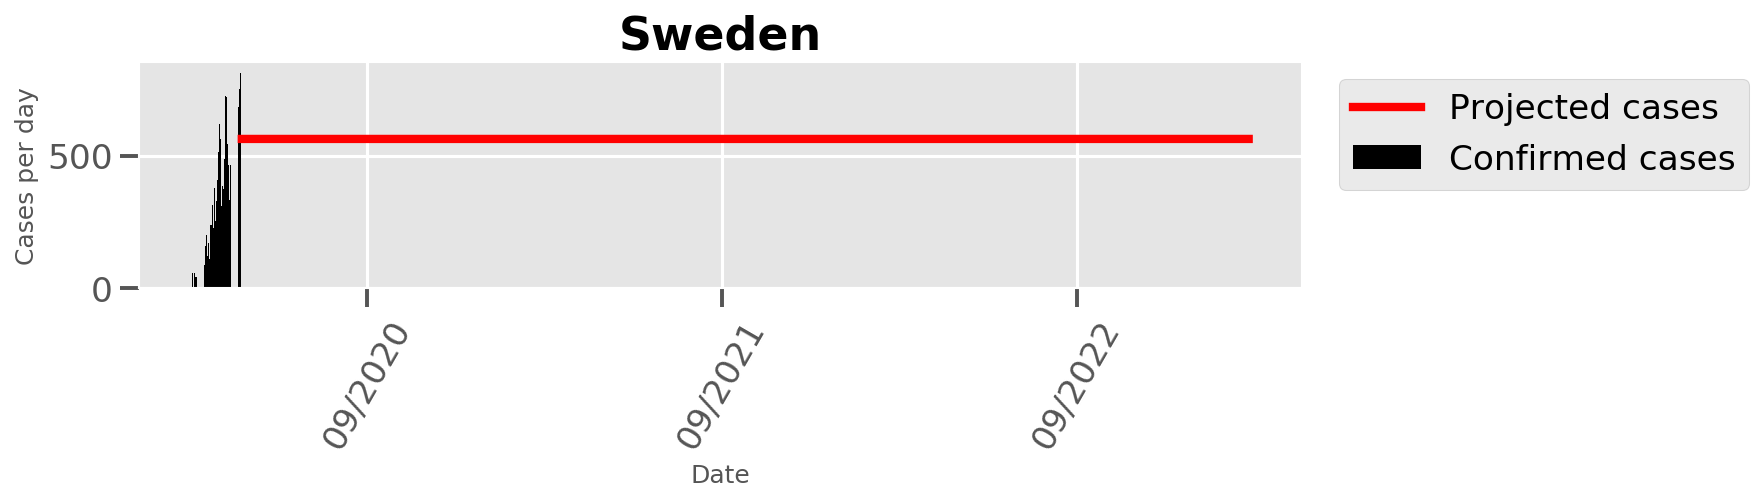

Switzerland


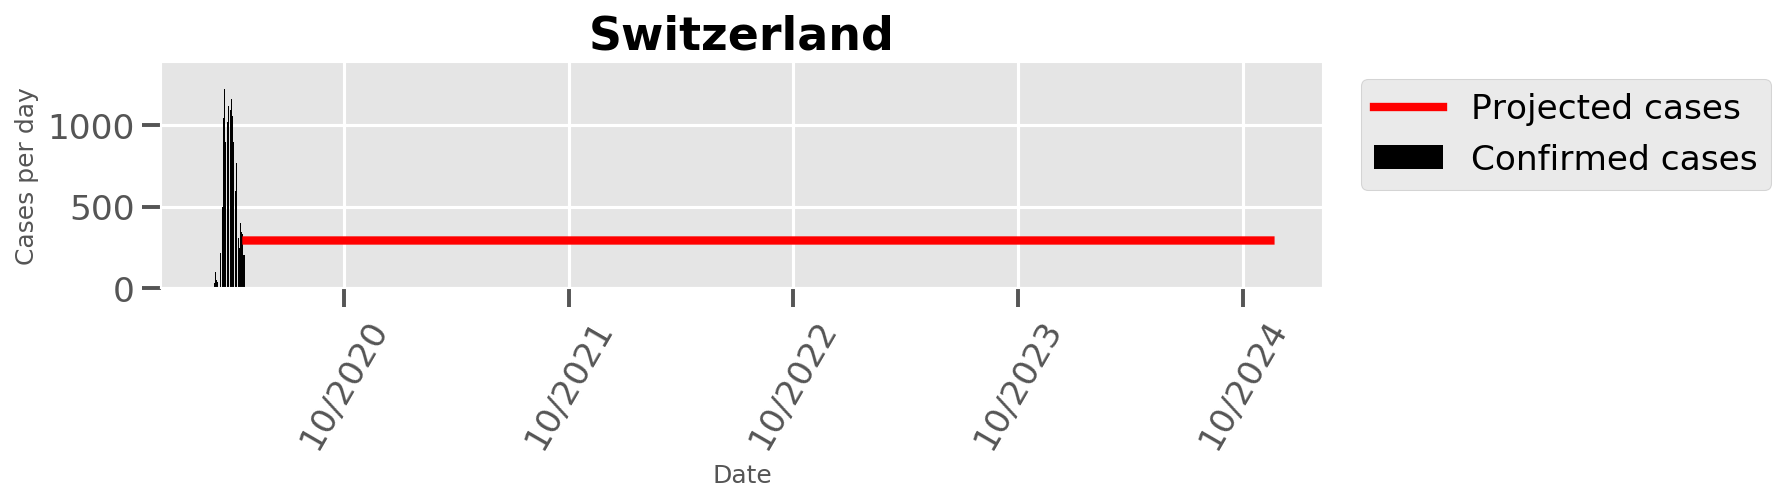

Mexico


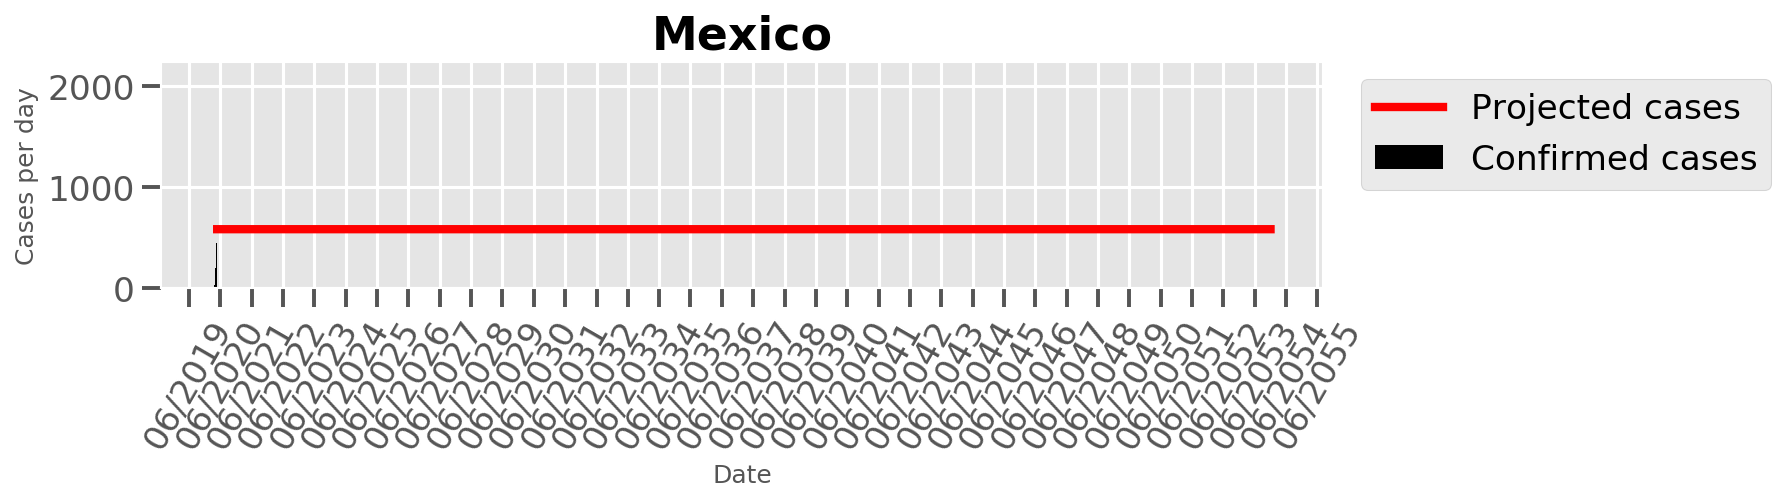

Ireland


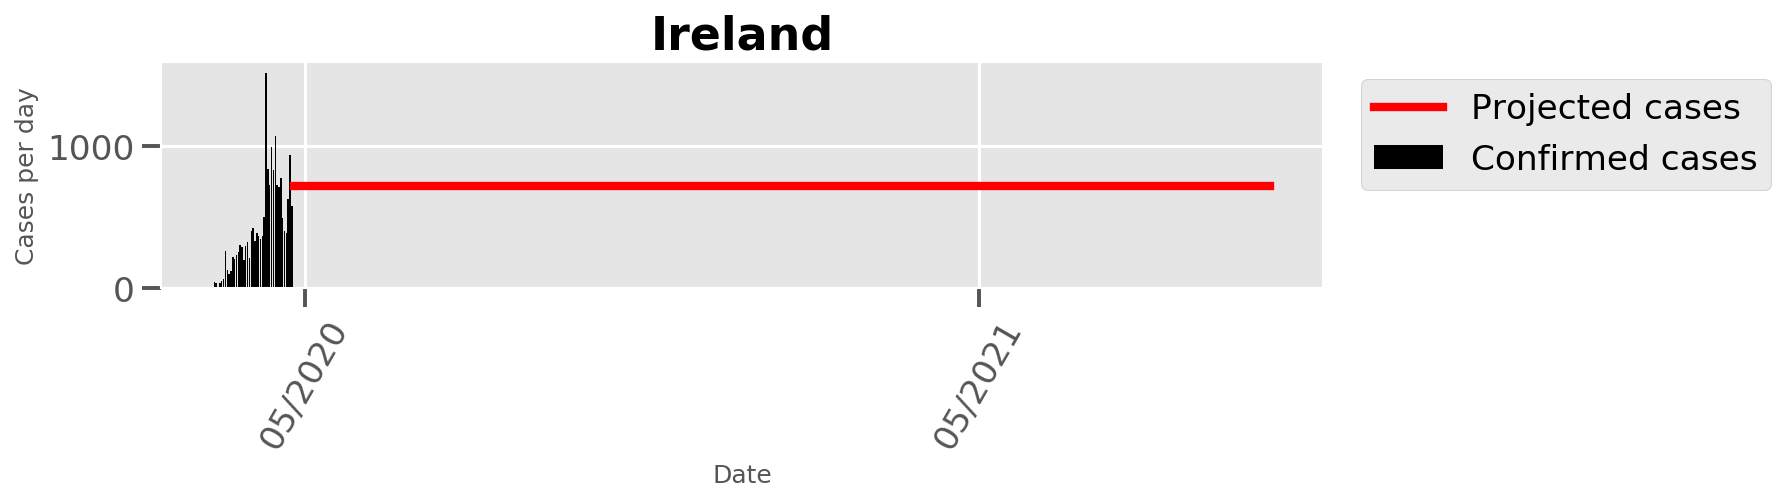

Portugal


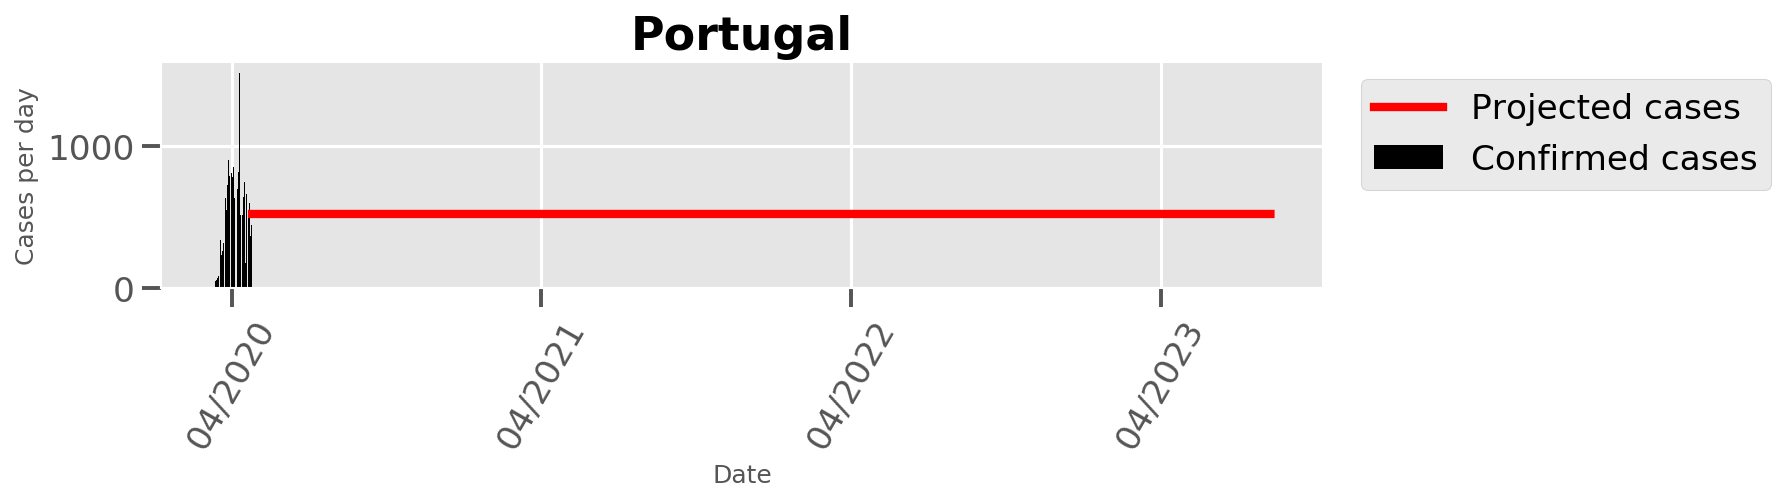

India


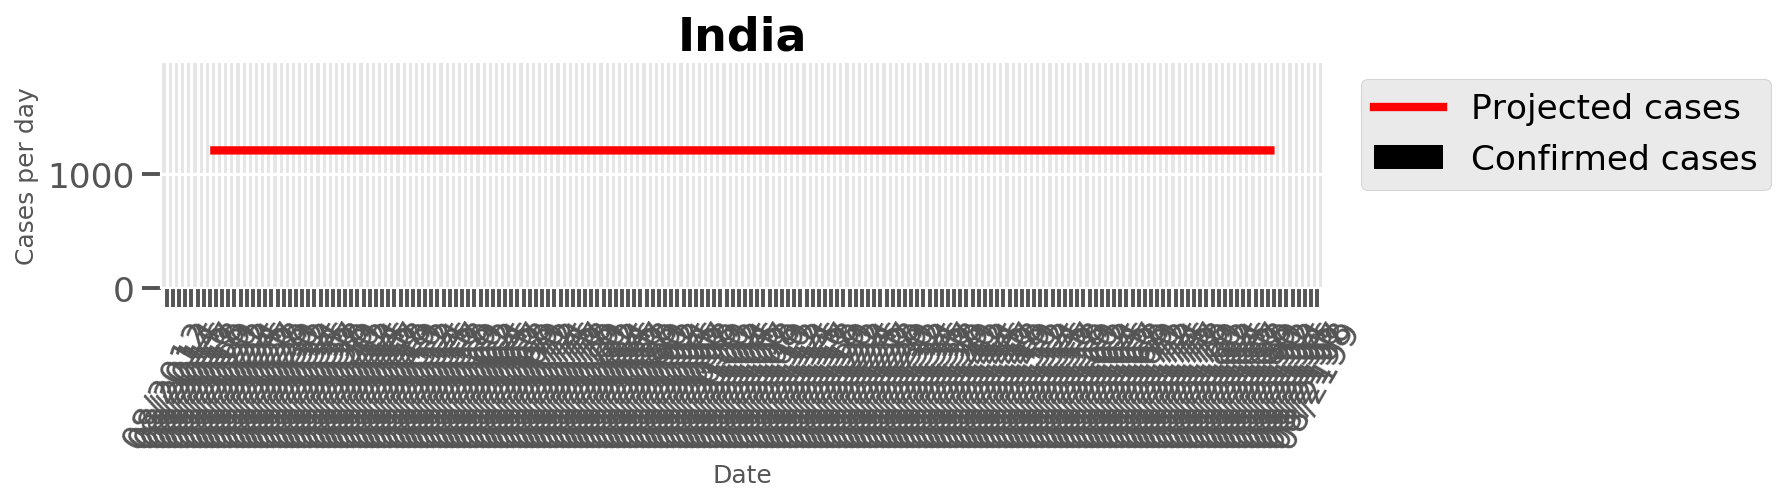

Peru


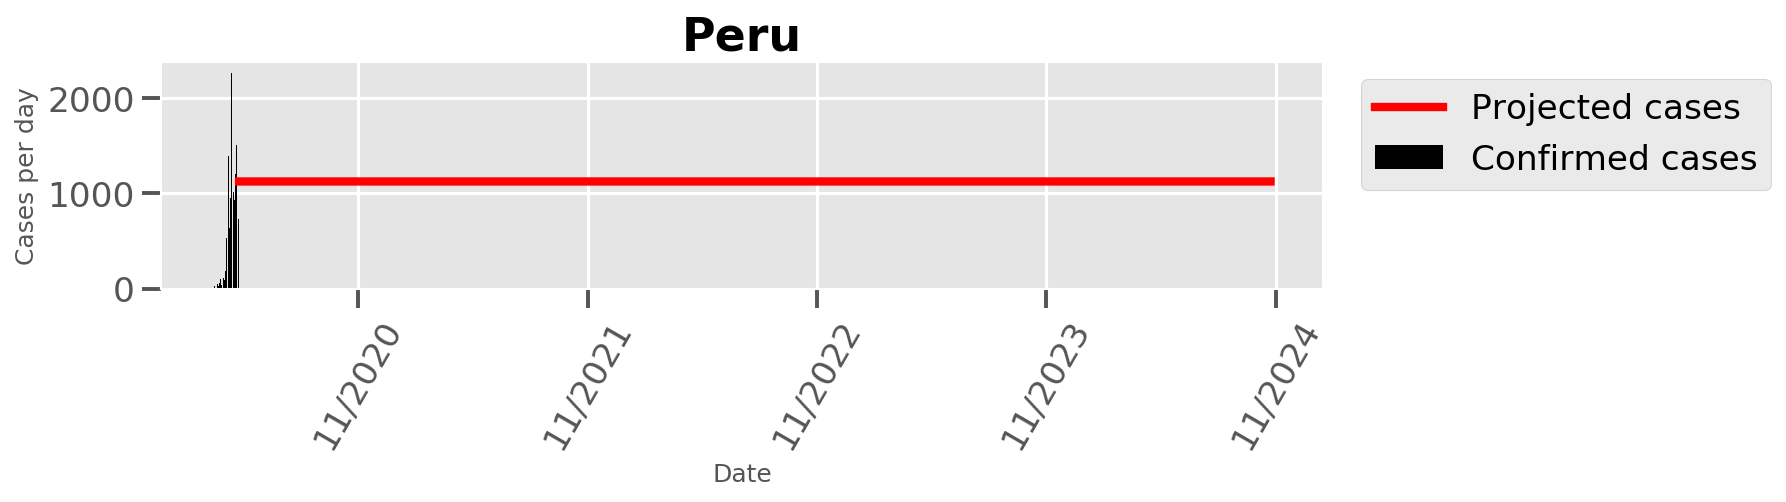

Russia


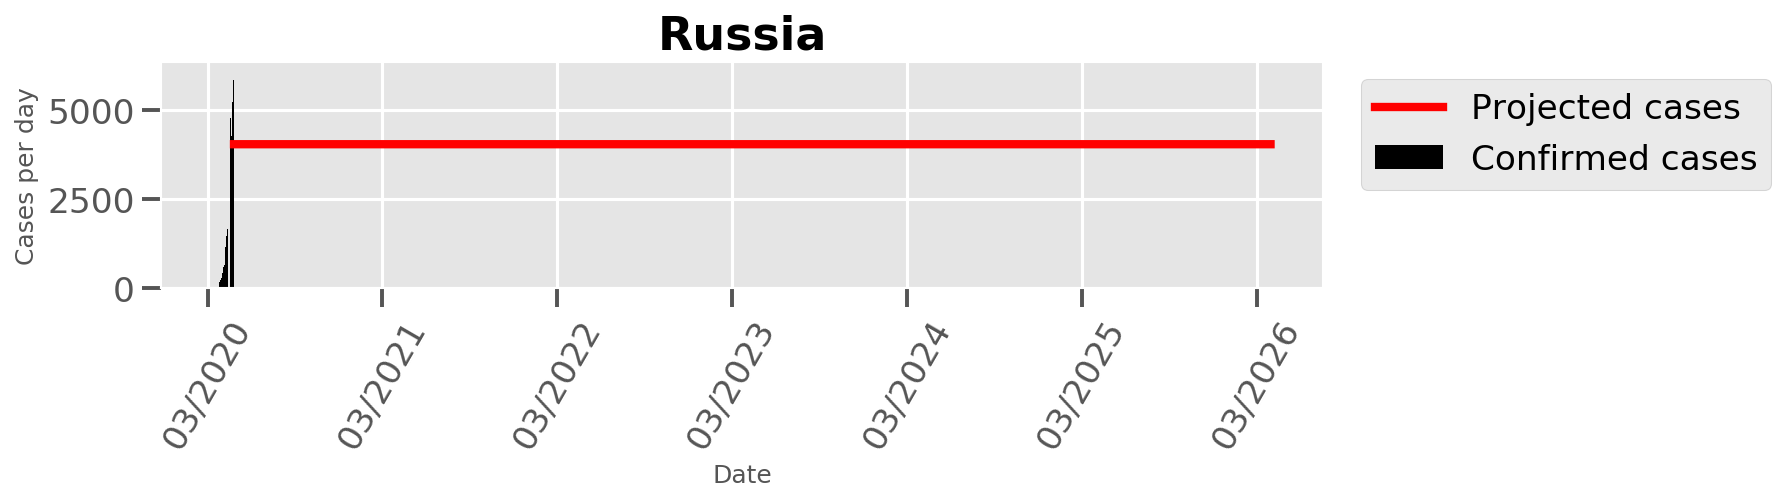

Ecuador


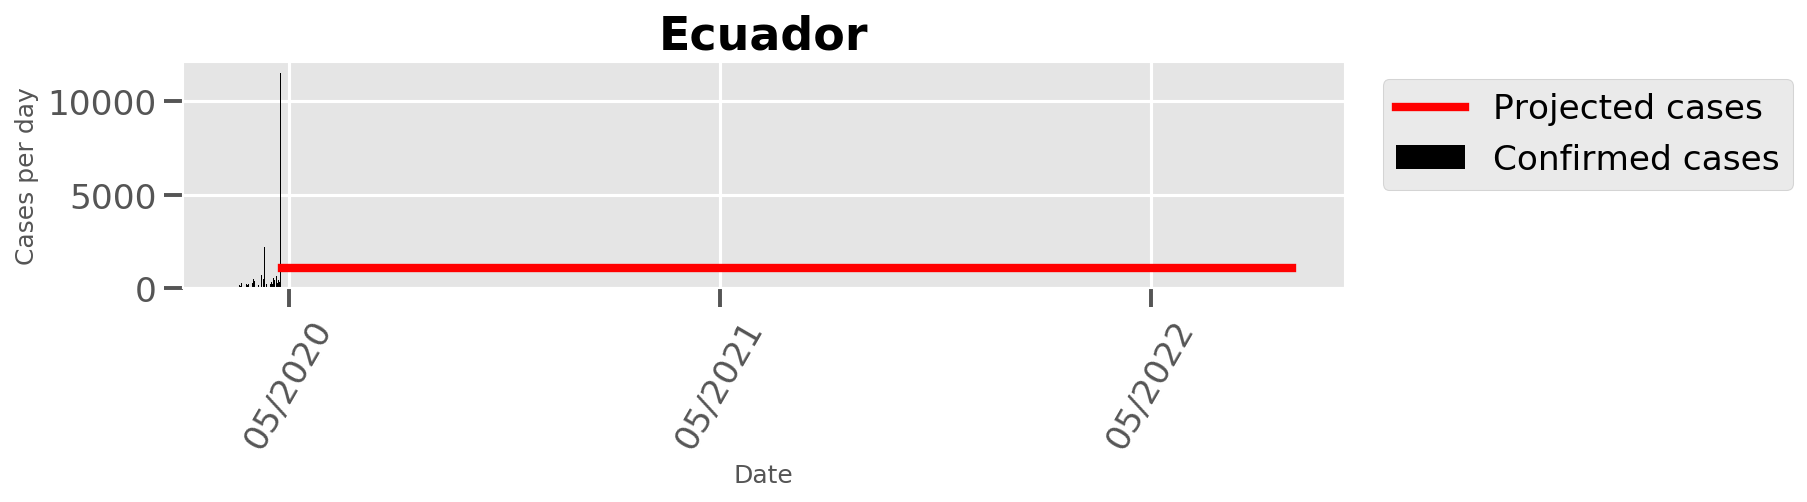

Romania


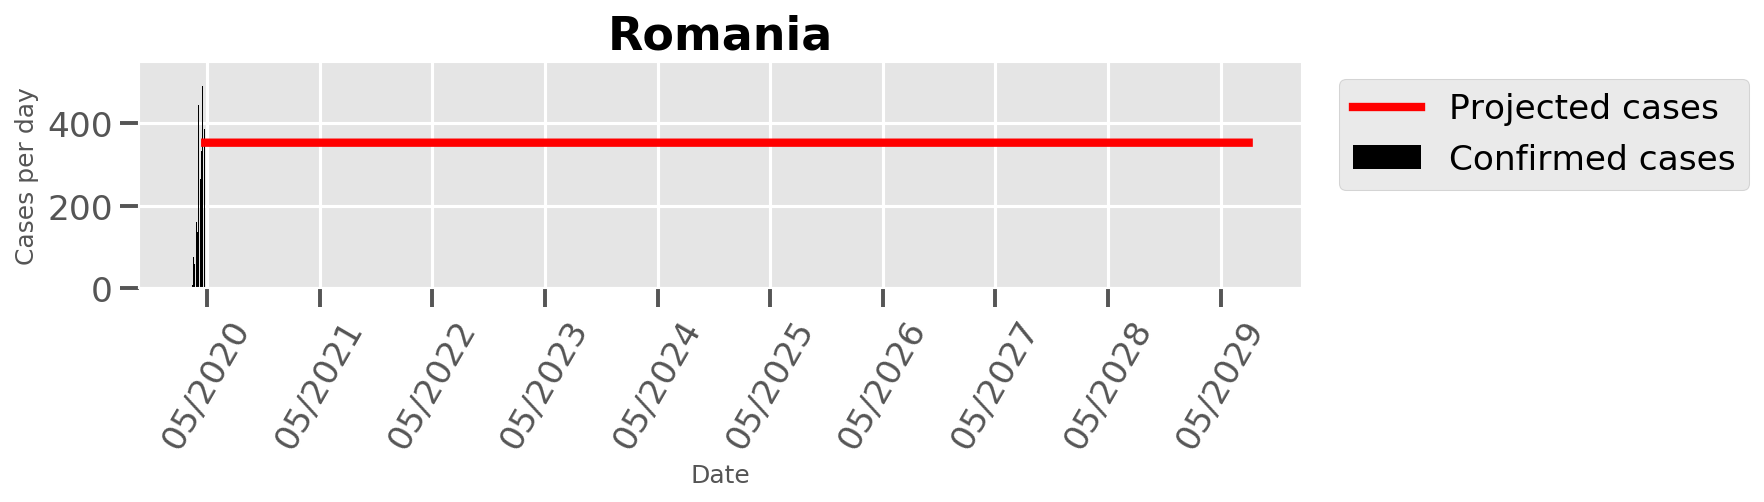

Austria


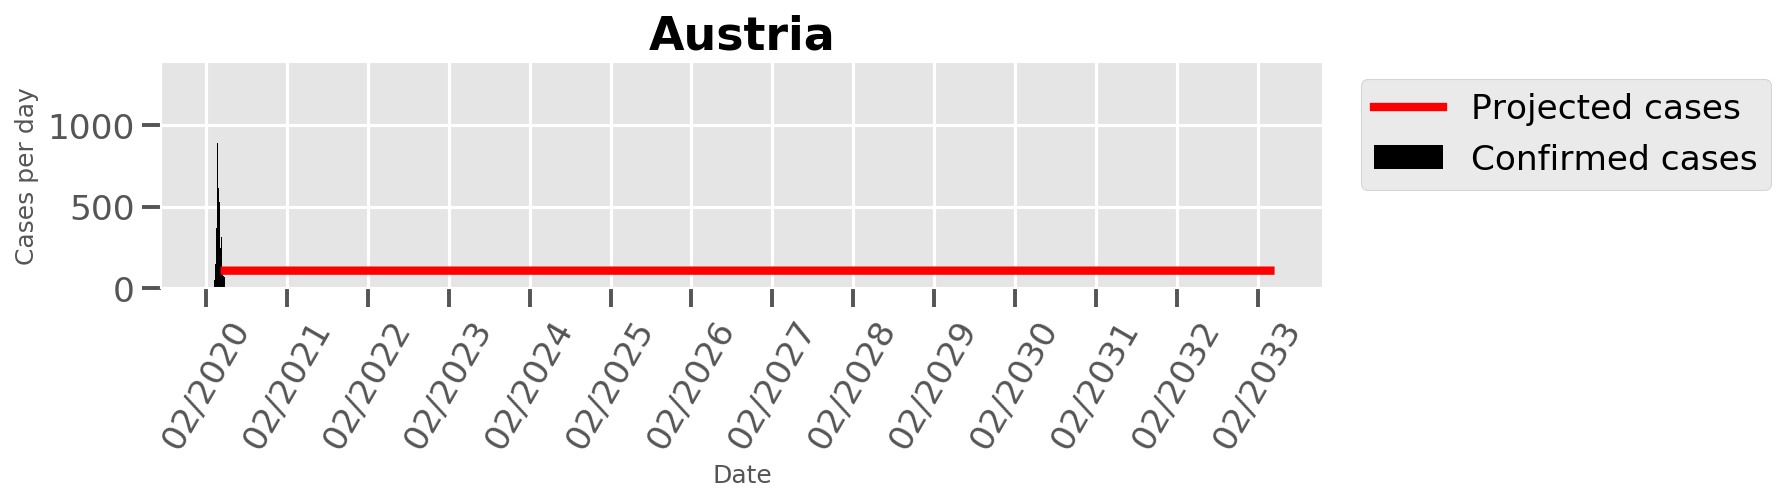

Poland


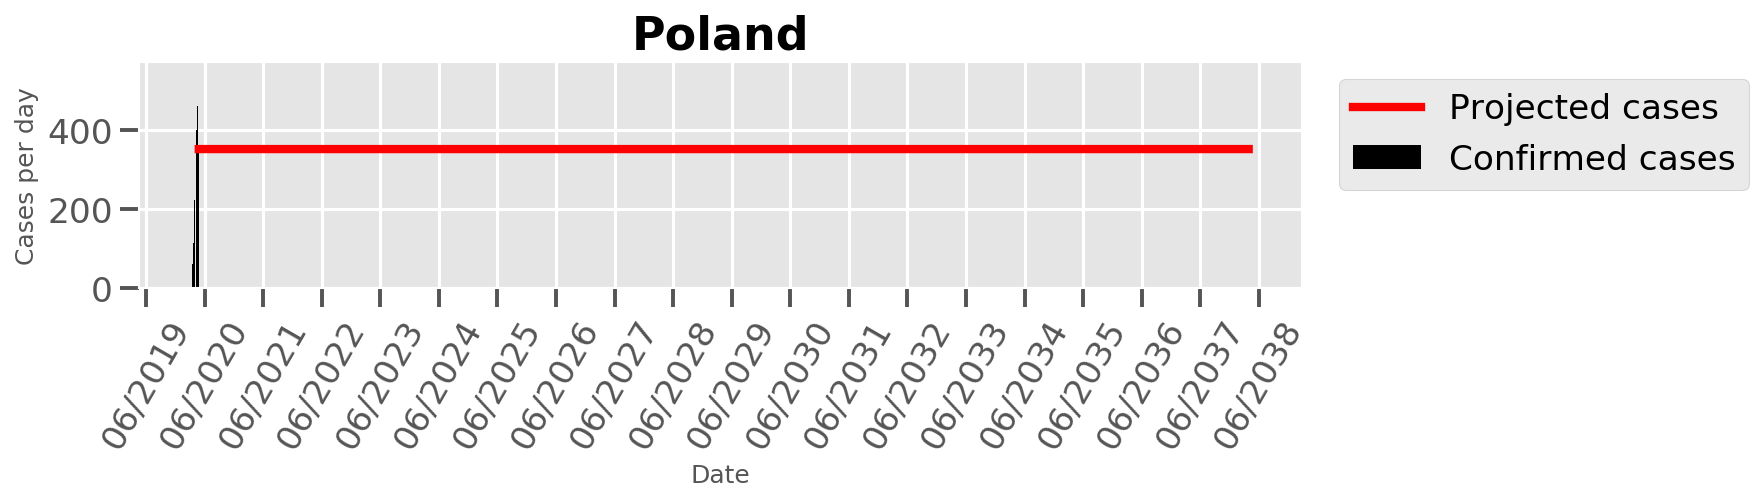

Japan


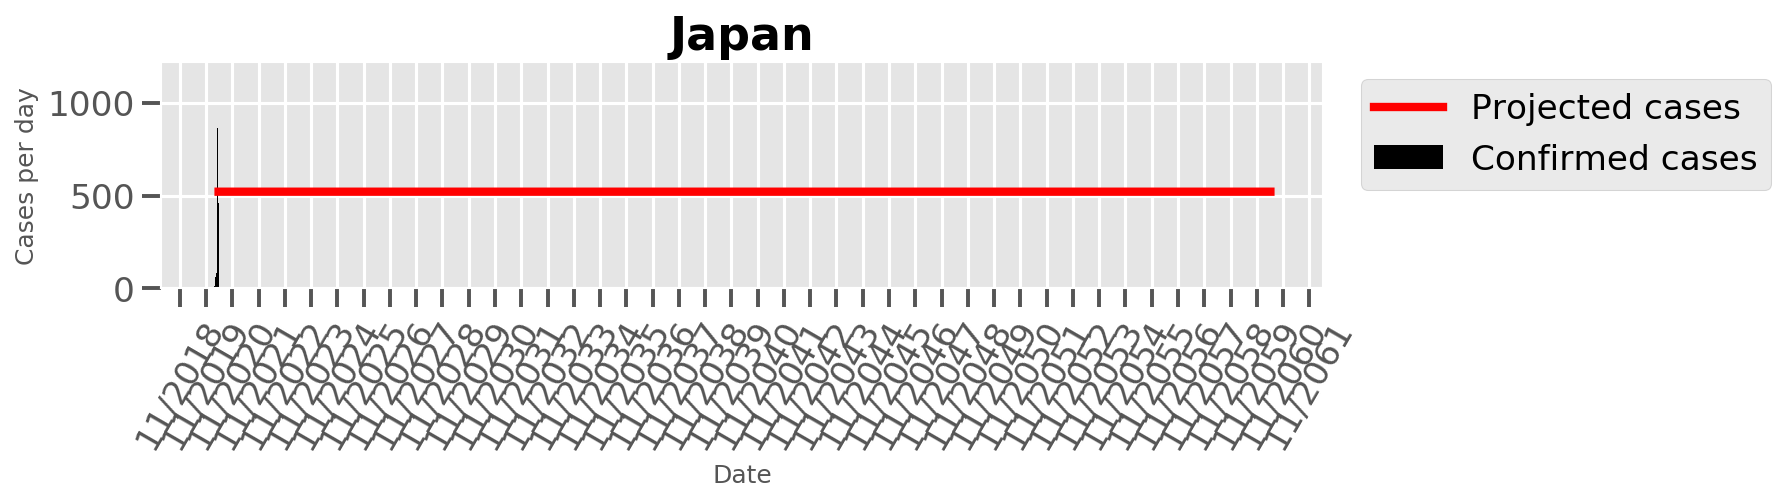

Pakistan


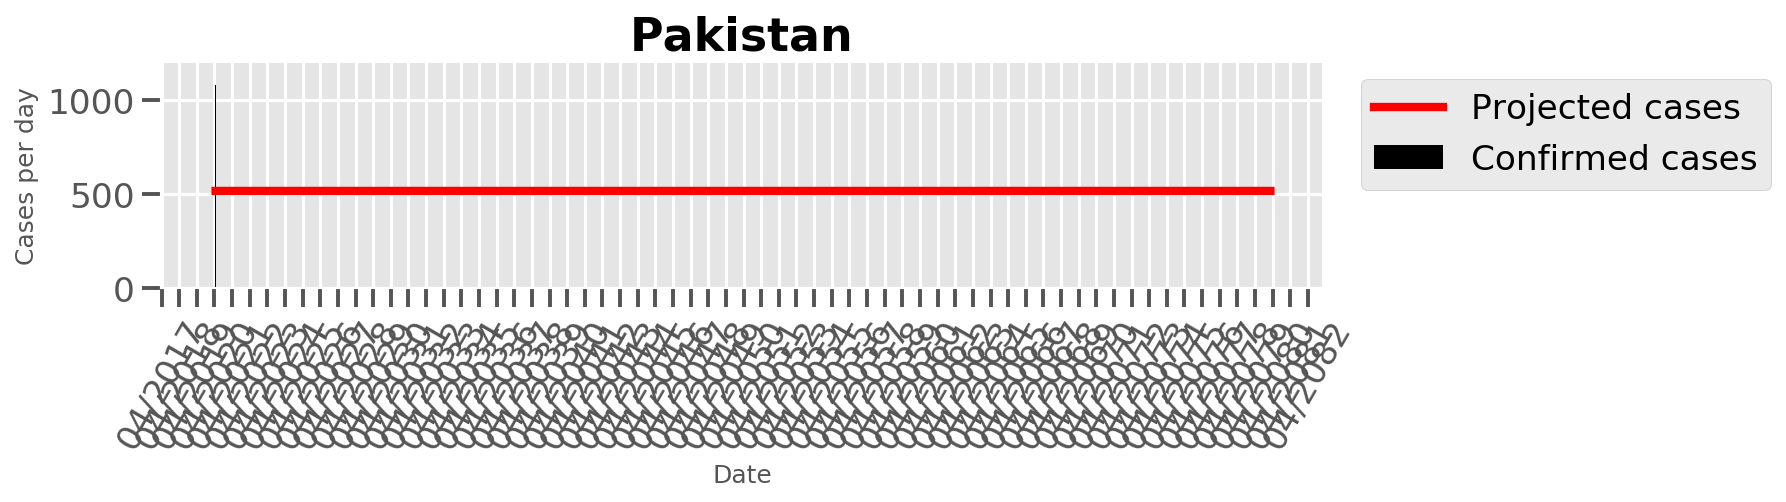

South Korea


OutOfBoundsDatetime: Cannot generate range with start=1587772800000000000 and periods=158045

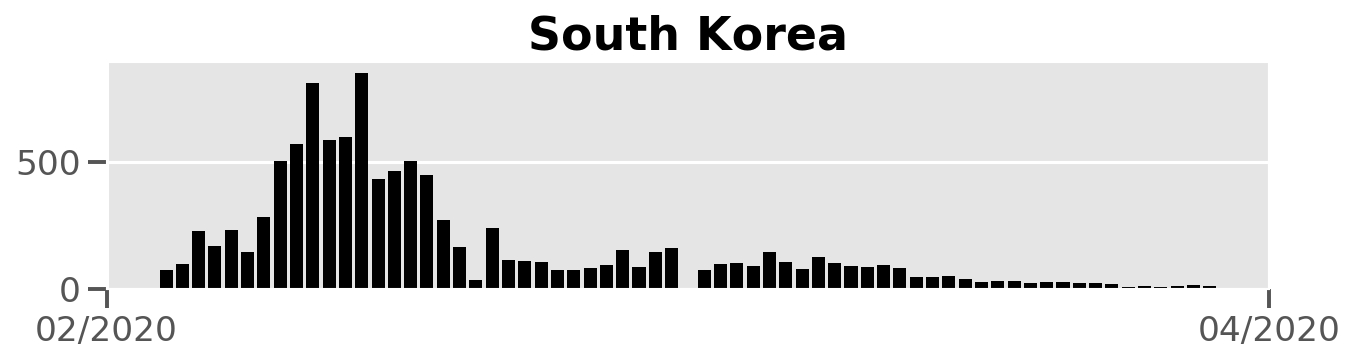

In [55]:
#hide
#fig, axs = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
DAYS_INFECTION_TO_DEATH = 23
#FATALITY_RATE = 0.01

ignore = [] #["China", "Switzerland"]
for i, str_country in enumerate(countries):
    print(f"{str_country}")
    df_cases_country = dff2[dff2['country']==str_country]      

    fig, axs = plt.subplots(1, 1, figsize=(10, 2), dpi=150)
    axs.set_title(f"{str_country}", fontsize=22, fontweight="bold")
    axs.bar(df_cases_country.index, df_cases_country.new_confirmed, lw=4, label=f"Confirmed cases", color='k')
    
    axs.xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every x months
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y')) 
    
    days_to_go = int(days_until_full_infection_list[i]) // 10
    projected_cases_per_day = int(new_cases_mean_list[i])
    last_date = df_cases_country.iloc[[-1]].index + datetime.timedelta(days=1)
    future_cases = pd.DataFrame(index=pd.date_range(last_date[0], periods=int(days_to_go), freq='D'), columns=['new_confirmed'])
    future_cases['new_confirmed'] = projected_cases_per_day
    
   
    axs.plot(future_cases.index, future_cases.new_confirmed, lw=4, color='r', label=f"Projected cases",)
    
    
    axs.legend(bbox_to_anchor=(1.4, 1.0))

    plt.xlabel(f"Date")
    plt.xticks(rotation=60)
    axs.set_ylabel(f"Cases per day")
    plt.show()
        

In [11]:
#hide

# FETCH
base_url = 'https://raw.githubusercontent.com/pratapvardhan/notebooks/master/covid19/'
paths = {
    'mapping': base_url + 'mapping_countries.csv',
    'overview': base_url + 'overview.tpl'
}

def get_mappings(url):
    df = pd.read_csv(url)
    return {
        'df': df,
        'replace.country': dict(df.dropna(subset=['Name']).set_index('Country')['Name']),
        'map.continent': dict(df.set_index('Name')['Continent'])
    }

mapping = get_mappings(paths['mapping'])

def get_template(path):
    from urllib.parse import urlparse
    if bool(urlparse(path).netloc):
        from urllib.request import urlopen
        return urlopen(path).read().decode('utf8')
    return open(path).read()

def get_frame(name):
    url = (
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
        f'csse_covid_19_time_series/time_series_covid19_{name}_global.csv')
    df = pd.read_csv(url)
    # rename countries
    df['Country/Region'] = df['Country/Region'].replace(mapping['replace.country'])
    return df

def get_dates(df):
    dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]
    LAST_DATE_I = -1
    # sometimes last column may be empty, then go backwards
    for i in range(-1, -len(dt_cols), -1):
        if not df[dt_cols[i]].fillna(0).eq(0).all():
            LAST_DATE_I = i
            break
    return LAST_DATE_I, dt_cols

In [12]:
#hide
COL_REGION = 'Country/Region'
# Confirmed, Recovered, Deaths
df = get_frame('confirmed')
# dft_: timeseries, dfc_: today country agg
dft_cases = df
dft_deaths = get_frame('deaths')
dft_recovered = get_frame('recovered')
LAST_DATE_I, dt_cols = get_dates(df)

dt_today = dt_cols[LAST_DATE_I]
dt_5ago = dt_cols[LAST_DATE_I-5]


dfc_cases = dft_cases.groupby(COL_REGION)[dt_today].sum()
dfc_deaths = dft_deaths.groupby(COL_REGION)[dt_today].sum()
dfp_cases = dft_cases.groupby(COL_REGION)[dt_5ago].sum()
dfp_deaths = dft_deaths.groupby(COL_REGION)[dt_5ago].sum()

In [13]:
dft_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,784,840,906,933,996,1026,1092,1176,1279,1351
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,494,518,539,548,562,584,609,634,663,678
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,673,673,696,704,713,717,717,723,723,731
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,19,19,19,24,24,24,24,25,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,5,5
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
